In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_files
import os

In [ ]:
os.environ['KAGGLE_USERNAME'] = //your_kaggle_username
os.environ['KAGGLE_KEY']= //your_kaggle_api-key

In [ ]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 98% 324M/330M [00:02<00:00, 125MB/s]
100% 330M/330M [00:02<00:00, 141MB/s]


In [ ]:
!unzip -q '/content/face-mask-12k-images-dataset.zip' -d .

In [ ]:
train_dir = "/content/Face Mask Dataset/Train"
valid_dir = "/content/Face Mask Dataset/Validation"
test_dir = "/content/Face Mask Dataset/Test"

In [ ]:
train_for_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    samplewise_center = True,
    samplewise_std_normalization = True)
valid_for_gen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_generator = train_for_gen.flow_from_directory(
    train_dir,
    target_size =(224,224),
    batch_size = 64,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle=True
)

validation_generator = valid_for_gen.flow_from_directory(
    valid_dir,
    target_size = (224,224),
    batch_size = 64,
    class_mode = 'binary',
    color_mode = 'rgb',
    shuffle=False,
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
mobilenet = MobileNetV2(input_shape = (224, 224, 3), include_top = False)
for layer in mobilenet.layers:
    layer.trainable = False
    
mobilenet.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

In [ ]:
X = layers.AveragePooling2D(pool_size=(7, 7))(mobilenet.output)
X = layers.Flatten(name="flatten")(X)
X = layers.Dense(128, activation="relu")(X)
X = layers.Dropout(0.5)(X)
prediction = layers.Dense(1, activation= 'sigmoid')(X)
model = Model(inputs = mobilenet.input, outputs = prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
opt = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-4 / 20)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(train_generator, batch_size=64, epochs=20,
              validation_data=validation_generator, verbose=1)

Epoch 1/20
157/157 [==============================] - 155s 780ms/step - loss: 0.2934 - accuracy: 0.8716 - val_loss: 0.1178 - val_accuracy: 0.9538
Epoch 2/20
157/157 [==============================] - 121s 771ms/step - loss: 0.1072 - accuracy: 0.9636 - val_loss: 0.1002 - val_accuracy: 0.9663
Epoch 3/20
157/157 [==============================] - 121s 772ms/step - loss: 0.0834 - accuracy: 0.9712 - val_loss: 0.0888 - val_accuracy: 0.9725
Epoch 4/20
157/157 [==============================] - 121s 773ms/step - loss: 0.0646 - accuracy: 0.9780 - val_loss: 0.0822 - val_accuracy: 0.9737
Epoch 5/20
157/157 [==============================] - 122s 777ms/step - loss: 0.0582 - accuracy: 0.9816 - val_loss: 0.0791 - val_accuracy: 0.9737
Epoch 6/20
157/157 [==============================] - 124s 787ms/step - loss: 0.0510 - accuracy: 0.9820 - val_loss: 0.0842 - val_accuracy: 0.9712
Epoch 7/20
157/157 [==============================] - 122s 775ms/step - loss: 0.0471 - accuracy: 0.9860 - val_loss: 0.0802 -

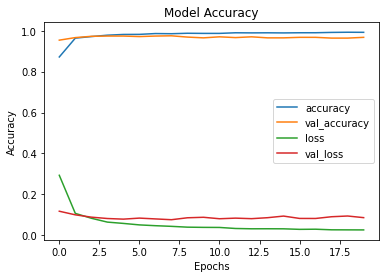

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['accuracy', 'val_accuracy','loss', 'val_loss'])
plt.show()

In [ ]:
model.save("masker_detector.model", save_format="h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
test_generator = ImageDataGenerator(
    rescale=1./255
)

sample_test = test_generator.flow_from_directory(
    test_dir,
    target_size = (224,224))

Found 992 images belonging to 2 classes.


In [ ]:
samples = sample_test.next()
predictions = np.squeeze(model.predict(samples[0]) >= 0.5).astype(np.int)
labels = samples[1].astype(np.int)

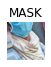

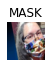

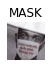

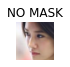

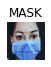

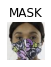

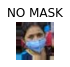

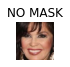

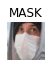

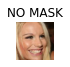

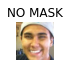

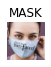

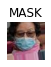

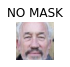

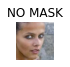

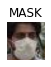

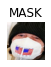

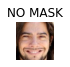

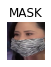

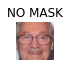

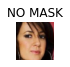

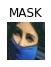

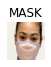

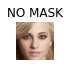

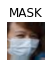

In [ ]:
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(samples[0][i])
    plt.axis('off')
    plt.title(("NO MASK" if predictions[i] == 1 else "MASK"))
    plt.show()

In [ ]:
tf.saved_model.save(model, '/content/saved_model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: /content/saved_model/assets


In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 64 kB 4.1 MB/s 


In [ ]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, '/content/converter')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model_load = tf.keras.models.load_model('/content/masker_detector.model')
model_load.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
model_load.evaluate(validation_generator)

13/13 [==============================] - 3s 136ms/step - loss: 0.0864 - accuracy: 0.9675


[0.08641748130321503, 0.9674999713897705]

In [ ]:
!zip -r /content/converter.zip /content/converter

  adding: content/converter/ (stored 0%)
  adding: content/converter/group1-shard1of3.bin (deflated 7%)
  adding: content/converter/group1-shard3of3.bin (deflated 7%)
  adding: content/converter/group1-shard2of3.bin (deflated 7%)
  adding: content/converter/model.json (deflated 96%)


In [ ]:
!zip -r /content/saved_model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/saved_model/variables/variables.index (deflated 77%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/saved_model.pb (deflated 92%)
